#   Black–Scholes Basics

> Rokhaya SONKO

#### Objectives
- Introduce the Black–Scholes model and its assumptions  
- Define the GBM dynamics under both P and Q measures  
- Present the closed-form formulas for European call/put options  
- Implement Black–Scholes pricing functions in Python  
- Visualize how prices depend on S, K, σ, T  
- Highlight limitations of the model and introduce the volatility smile

#### Imports

In [22]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.rcParams["figure.figsize"] = (8, 5)


#### 1. Underlying Dynamics: Geometric Brownian Motion (GBM)

The Black–Scholes framework assumes the underlying follows a GBM process.

- Under the **historical measure** 𝙋: $ dS_t = \mu S_t\,dt + \sigma S_t\,dW_t $
- Under the **risk-neutral measure** 𝙌: $ dS_t = r S_t\,dt + \sigma S_t\,dW_t^{\mathbb{Q}}$
- The drift changes from μ to r when moving to the risk-neutral measure.
- Volatility σ is constant.
- The distribution of $ S_T$ is lognormal.


> **In Black–Scholes, the only thing that changes between P and Q is the drift.**


#### 2. Black–Scholes Closed-Form Formulas

- European Call: $ C = S_0 N(d_1) - K e^{-rT}N(d_2)$
- European Put: $ P = K e^{-rT} N(-d_2) - S_0 N(-d_1)$

where:

- $d_1 = \frac{\ln(S_0/K) + (r + \tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}} \qquad$
- $d_2 = d_1 - \sigma\sqrt{T} $
- $N(d_1)$ = risk-neutral probability of finishing in-the-money (adjusted for growth)
- $N(d_2)$ = actual risk-neutral ITM probability


In [23]:
def bs_d1_d2(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return d1, d2

def bs_call(S, K, T, r, sigma):
    d1, d2 = bs_d1_d2(S, K, T, r, sigma)
    return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)

def bs_put(S, K, T, r, sigma):
    d1, d2 = bs_d1_d2(S, K, T, r, sigma)
    return K*np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)


#### 📉 3.  Sensitivity Analysis
Let's visualize how option prices move when changing spot or volatility. This provides intuition for Delta and Vega.


- **Price vs Spot**

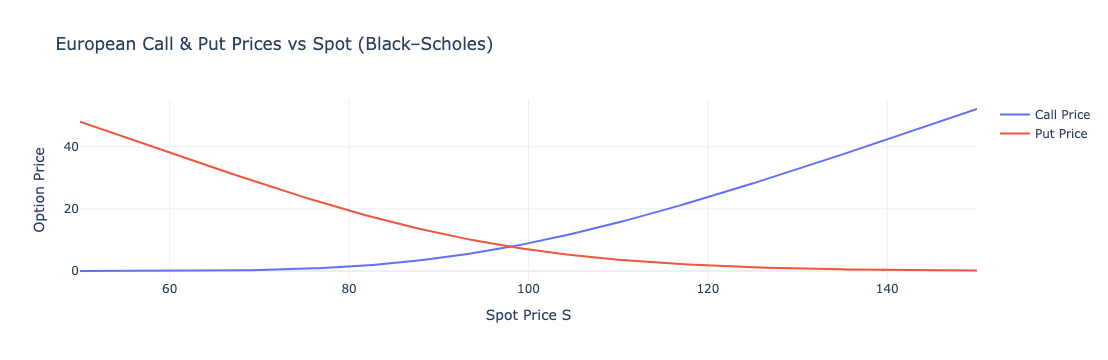

In [24]:
# Parameters
K = 100
T = 1.0
r = 0.02
sigma = 0.20

S_grid = np.linspace(50, 150, 200)
call_vals = [bs_call(S, K, T, r, sigma) for S in S_grid]
put_vals = [bs_put(S, K, T, r, sigma) for S in S_grid]

fig = go.Figure()
fig.add_trace(go.Scatter(x=S_grid, y=call_vals, mode="lines", name="Call Price"))
fig.add_trace(go.Scatter(x=S_grid, y=put_vals, mode="lines", name="Put Price"))

fig.update_layout(
    title="European Call & Put Prices vs Spot (Black–Scholes)",
    xaxis_title="Spot Price S",
    yaxis_title="Option Price",
    template="plotly_white"
)

fig.show()



- Call price increases with S (positively sloped).
- Put price decreases with S (negatively sloped).
- Slopes corresponds to Delta.


- **Price vs Volatility**

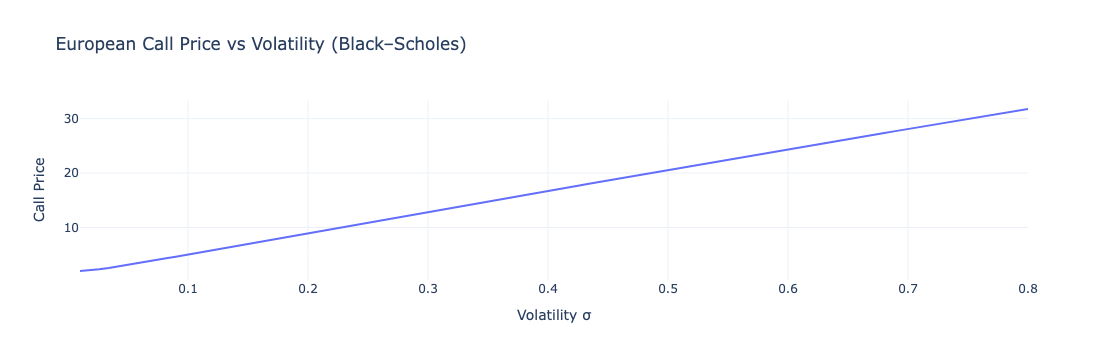

In [25]:
S0 = 100
sigma_grid = np.linspace(0.01, 0.8, 100)
call_sigma_vals = [bs_call(S0, K, T, r, s) for s in sigma_grid]

fig_sigma = go.Figure()
fig_sigma.add_trace(
    go.Scatter(x=sigma_grid, y=call_sigma_vals, mode="lines", name="Call Price"))

fig_sigma.update_layout(
    title="European Call Price vs Volatility (Black–Scholes)",
    xaxis_title="Volatility σ",
    yaxis_title="Call Price",
    template="plotly_white")

fig_sigma.show()


- As volatility $\sigma$ increases, the **call price increases**.
- Intuition: a call has a **convex payoff**; more uncertainty increases the expected payoff.
- The slope of this curve corresponds to **Vega** (sensitivity to volatility).

#### 4. Put–Call Parity

For European options with the same:
- maturity  T
- strike  K
- underlying

the following **no-arbitrage relationship** holds: $ C - P = S_0 - K e^{-rT}$

In [26]:
S0 = 100
K = 100
T = 1.0
r = 0.02
sigma = 0.20

C = bs_call(S0, K, T, r, sigma)
P = bs_put(S0, K, T, r, sigma)

lhs = C - P
rhs = S0 - K * np.exp(-r * T)

print(lhs)
print(rhs)
print(lhs - rhs)

1.980132669324469
1.980132669324476
-7.105427357601002e-15


- `lhs` = \( C - P \)  
- `rhs` = \( S_0 - K e^{-rT} \)

If the numerical difference `lhs - rhs` is very close to zero, the put–call parity is satisfied up to floating-point precision.
In real markets: Deviations from parity can signal **arbitrage opportunities**, or more commonly: **funding constraints**, **dividends**, or **market frictions**.


#### 5. Limitations of the Black–Scholes Model

The Black–Scholes assumptions are quite strong and not realistic:
- Volatility $\sigma$ is **constant** over time.
- The underlying has **continuous paths** (no jumps).
- Interest rates are **constant** and known.
- The underlying follows a **lognormal distribution**.
- No transaction costs, no funding issues, continuous trading.

In reality, when we back out implied volatilities from market option prices:
- Implied vol depends on `strike` and `maturity`.
- Equity markets show a **downward skew** (OTM puts more expensive).
- FX markets show **smiles** or **smirks**.

Black–Scholes **cannot** reproduce these smiles/skews.
> Black–Scholes is a benchmark. It cannot match the implied volatility smile observed in real markets.

This motivates (in next notebooks):
- Volatility smile modelling (SABR, SVI, Heston).
- Local volatility (Dupire).
- More advanced numerical methods (PDE, Monte Carlo under richer models).
